# Sampling wavelet sparsity

Suppose we collect complete observations $y \in \mathbb{R}^N$ of some image $x \in \mathbb{R}^N$ under a trivial forward model $\Phi = \mathbb{I}$. Suppose further that our observational instrument introduces some aleoteric uncertainty which can be adequately modelled by a univariate Gaussian $n = \mathcal{N}(0, \sigma) \in \mathbb{R}^N$. In this case our measurement equation is given by $$y = x + n.$$

Under these conditions the inverse problem of infering $x$ given $y$ is degenerate and thus breaks [Hadamards](https://en.wikipedia.org/wiki/Well-posed_problem) second condition: the solution is not unique and thus the inverse problem is ill-posed. Given that inferences of $x$ are degenerate it naturally makes more sense to consider the probability distribution of possible solutions; the posterior distribution. Here we use **proximal nested sampling** ([Cai *et al* 2022](https://arxiv.org/abs/2106.03646)), which allows us to sample from this posterior distribution, recovering both an estimate of $x$ and the plausibility of this estimate. Moreover, as this is a nested sampling algorithm we automatically recover the Bayesian evidence, which naturally allows us to carry out model comparison, through which one can *e.g.* determine which forward models $\Phi$ are favoured by the data, or calibrate hyper-parameters of the problem such as $\sigma$ and regularisation parameters $\lambda$.



In [1]:
import numpy as np
import ProxNest.utils as utils
import ProxNest.sampling as sampling
import ProxNest.optimisations as optimisations
import ProxNest.operators as operators

### Load ground truth image

In [2]:
# Load Image
dim = 64
ground_truth = np.load('../data/galaxy_image_{}.npy'.format(dim))

# Normalise magnitude
ground_truth -= np.nanmin(ground_truth)
ground_truth /= np.nanmax(ground_truth)
ground_truth[ground_truth<0] = 0

### Define problem and simulate data

In [3]:
# A simple identity forward model
phi = operators.sensing_operators.Identity()

# A wavelet dictionary in which we can promote sparsity
psi = operators.wavelet_operators.db_wavelets(["db6"], 2, (dim, dim))

In [4]:
# Define noise parameters
ISNR = 20
sigma = np.sqrt(np.mean(np.abs(ground_truth)**2)) * 10**(-ISNR/20)
n = np.random.normal(0, sigma, ground_truth.shape)

# Simulate mock noisy observations
y = phi.dir_op(ground_truth) + n

### Create proximal lambda functions

In [5]:
# Parameter dictionary associated with optimisation problem of resampling from the prior subject to the likelihood iso-ball
params = utils.create_parameters_dict(
           y = y,                    # Measurements i.e. data
         Phi = phi,                  # Forward model
     epsilon = 1e-3,                 # Radius of L2-ball of likelihood 
       tight = True,                 # Is Phi a tight frame or not?
          nu = 1,                    # Bound on the squared-norm of Phi
         tol = 1e-10,                # Convergence tolerance of algorithm
    max_iter = 200,                  # Maximum number of iterations
     verbose = 0,                    # Verbosity level
           u = 0,                    # Initial vector for the dual problem
         pos = False,                # Positivity flag
     reality = False                 # Reality flag
)

# Options dictionary associated with the overall sampling algorithm
options = utils.create_options_dict(
    samplesL = 1e2,                  # Number of live samples
    samplesD = 1e3,                  # Number of discarded samples 
    thinning = 1e1,                  # Thinning factor (to mitigate correlations)
       delta = 1e-8,                 # Discretisation stepsize
        burn = 1e1,                  # Number of burn in samples
       sigma = sigma                 # Noise standard deviation of degraded image
)

In [6]:
# Regularisation parameter
delta = 3e5

# Lambda functions to evaluate cost function
LogLikeliL = lambda sol : - np.linalg.norm(y-phi.dir_op(sol), 'fro')**2/(2*sigma**2)

# Lambda function for L1-norm wavelet prior backprojection steps
proxH = lambda x, T : operators.proximal_operators.l1_projection(x, T, delta, Psi=psi)

# Lambda function for L2-ball likelihood projection during resampling
proxB = lambda x, tau: optimisations.l2_ball_proj.sopt_fast_proj_B2(x, tau, params)

### Execute proximal nested sampling

In [7]:
# Create a 'dirty image' starting position
X0 = np.abs(phi.adj_op(y))

# Perform proximal nested sampling
NS_BayEvi, NS_Trace = sampling.proximal_nested.ProxNestedSampling(X0, LogLikeliL, proxH, proxB, params, options)

ProxNest || Initialise: 100%|██████████| 200/200 [00:00<00:00, 1479.56it/s]
ProxNest || Populate: 100%|██████████| 1008/1008 [00:00<00:00, 2674.17it/s]
ProxNest || Sample: 100%|██████████| 1000/1000 [00:05<00:00, 175.63it/s]
ProxNest || Compute Weights: 100%|██████████| 1000/1000 [00:00<00:00, 1492634.88it/s]
ProxNest || Trapezium Integrate: 100%|██████████| 998/998 [00:00<00:00, 1207011.36it/s]
ProxNest || Estimate Variance: 100%|██████████| 1000/1000 [00:00<00:00, 431379.62it/s]
ProxNest || Compute Posterior Mean: 100%|██████████| 1000/1000 [00:00<00:00, 557382.59it/s]


### Visualise posterior mean

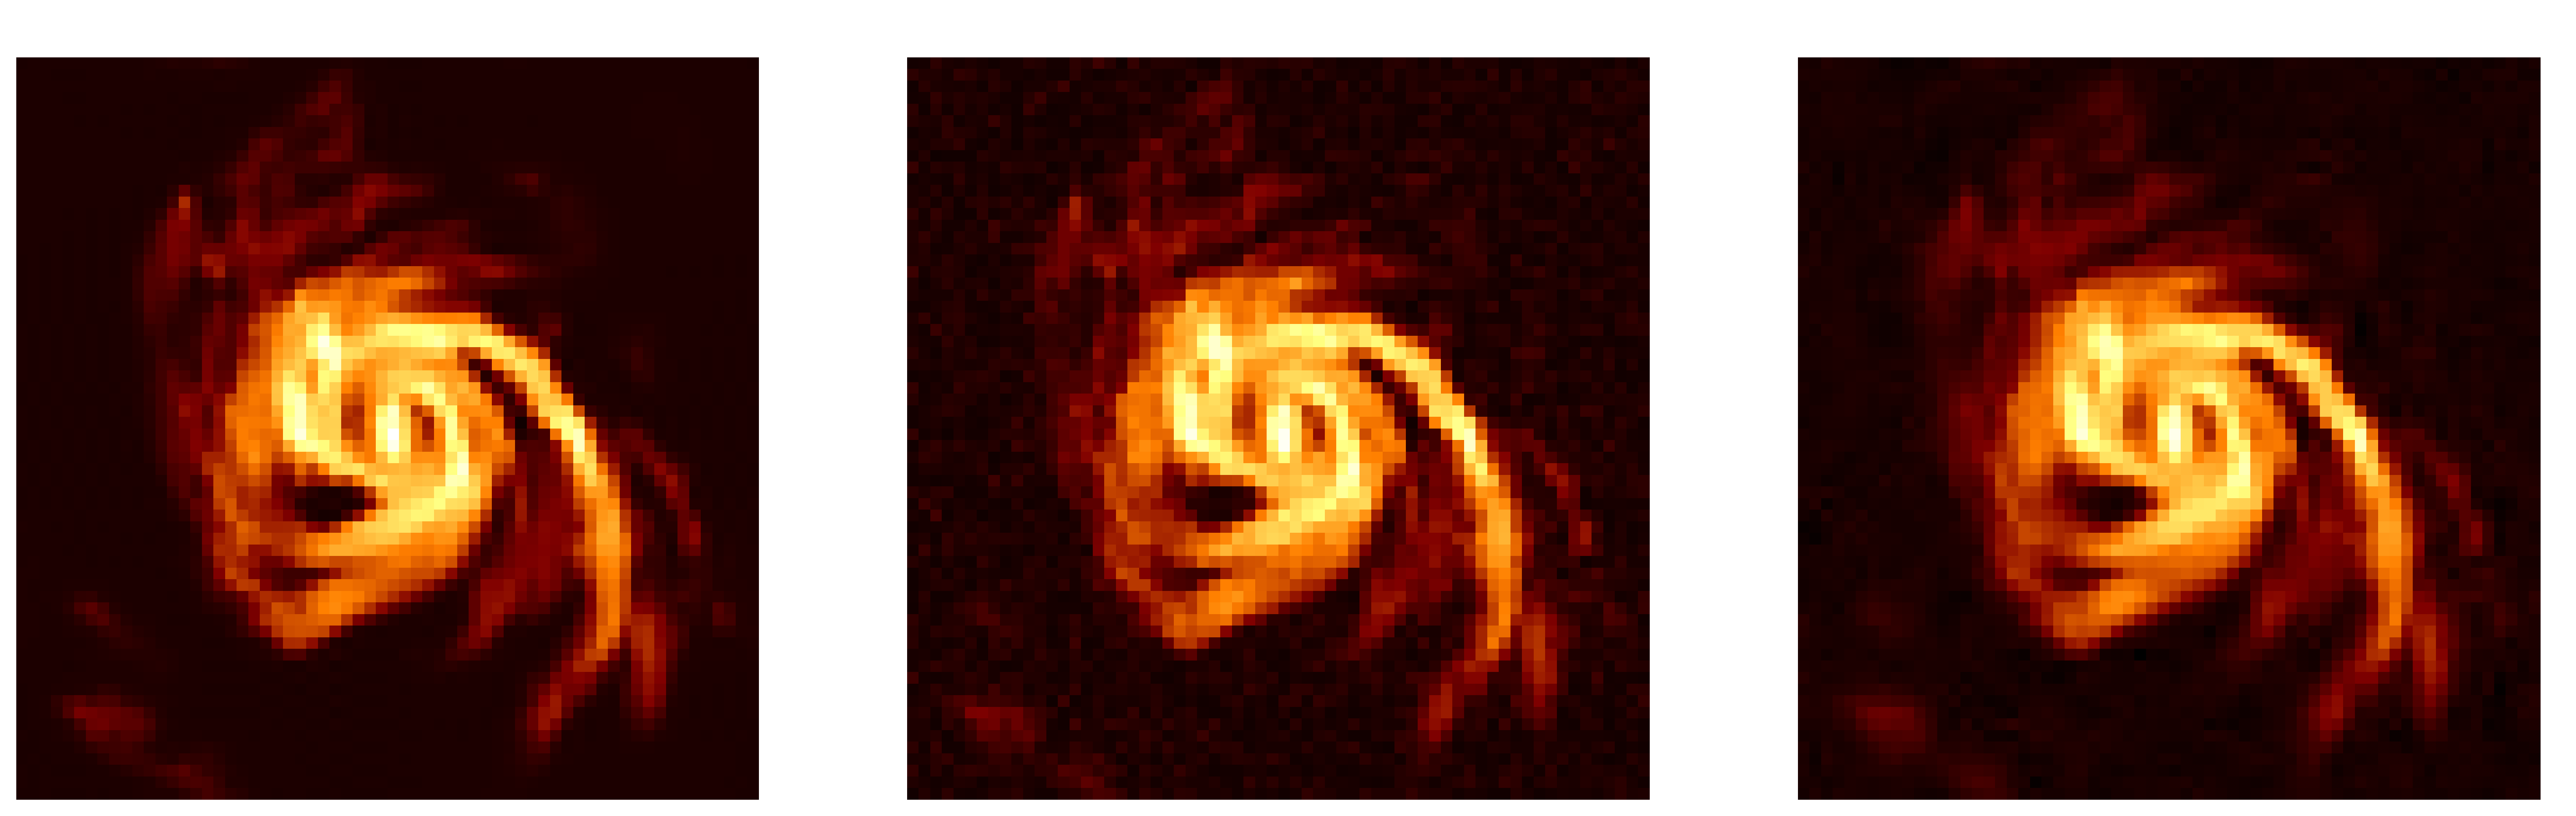

In [8]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
plt.style.use('dark_background')
plt.rcParams["font.family"] = "serif"

images = [ground_truth, X0, NS_Trace['DiscardPostMean']]
labels = ["Truth", "Dirty", "Posterior mean"]

fig, axs = plt.subplots(1,3, figsize=(20,8), dpi=400)
for i in range(3):
    axs[i].imshow(images[i], cmap='afmhot', vmax=np.nanmax(images), vmin=np.nanmin(images))
    if i > 0:   
        stats_str = ' (PSNR: {}, SSIM: {})'.format(
            round(psnr(ground_truth, images[i]), 2),
            round(ssim(ground_truth, images[i]), 2)
            )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')

plt.show()